**Import Library**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns



**Scrape data harga emas**

In [2]:
import requests
import pandas as pd

# Scrape data dengan API
response = requests.get("https://pluang.com/api/asset/gold/pricing?daysLimit=20000")
coba = response.json()

# manipulasi data dan transformasi periode data
hargaemas = pd.DataFrame(coba['data']['history'])
hargaemas['tgl'] = pd.to_datetime(hargaemas['updated_at'].str[:10], format="%Y-%m-%d")
hargaemas = hargaemas.iloc[:, [1, 2, 3, 5]]

hargaemas.to_csv('hargaemas.csv', index=False)

# sekilas data
hargaemas.head()

,sell,buy,installment,tgl
0,1836592,1790677,1836592,2025-05-18
1,1836592,1790677,1836592,2025-05-17
2,1837102,1791174,1837102,2025-05-16
3,1813442,1768105,1813442,2025-05-15
4,1837283,1791350,1837283,2025-05-14


**Visualisasi**


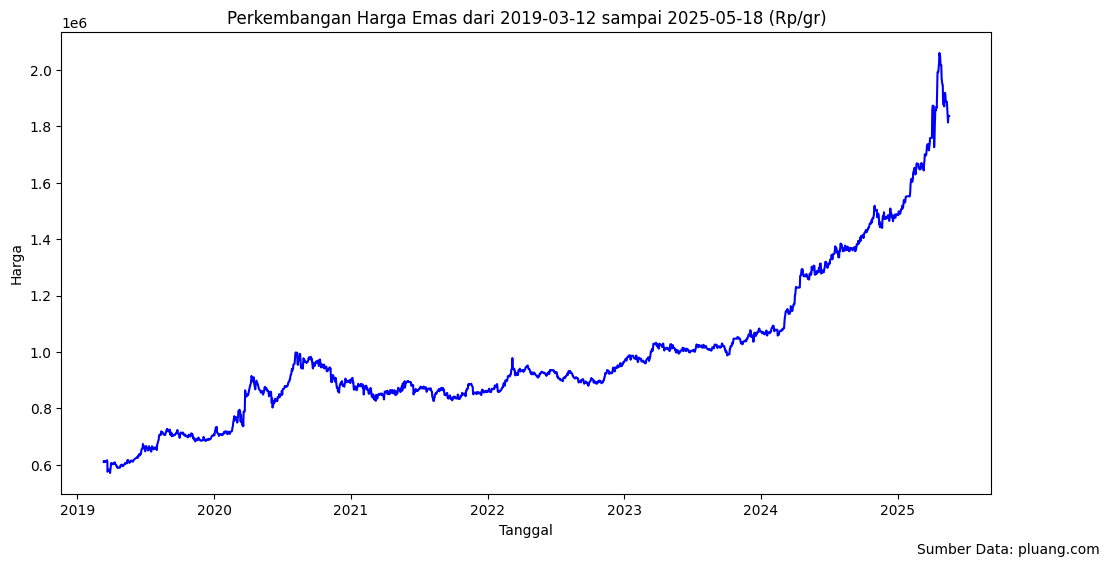

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(hargaemas['tgl'], hargaemas['sell'], color='blue')
plt.xlabel("Tanggal")
plt.ylabel("Harga")
plt.title(f"Perkembangan Harga Emas dari {hargaemas['tgl'].min().date()} sampai {hargaemas['tgl'].max().date()} (Rp/gr)")
plt.figtext(0.99, 0.01, "Sumber Data: pluang.com", horizontalalignment='right')
plt.show()


**Membaca Data dan Praproses**

In [4]:
# Membaca file CSV yang sudah diunduh
file_path = 'hargaemas.csv'  # Gantilah dengan path file Anda
data = pd.read_csv(file_path)

# Mengonversi kolom 'tgl' menjadi format tanggal
data['tgl'] = pd.to_datetime(data['tgl'])

# Menghitung moving average untuk harga jual (sell) dan beli (buy)
data['sell_ma'] = data['sell'].rolling(window=5).mean()  # Moving average untuk harga jual (5 hari)
data['buy_ma'] = data['buy'].rolling(window=5).mean()  # Moving average untuk harga beli (5 hari)

# Menggunakan ffill() untuk mengisi nilai NaN secara langsung
data['sell_ma'] = data['sell_ma'].ffill()
data['buy_ma'] = data['buy_ma'].ffill()

# Memeriksa data setelah mengisi NaN
print(data.head())

      sell      buy  installment        tgl    sell_ma     buy_ma
0  1836592  1790677      1836592 2025-05-18        NaN        NaN
1  1836592  1790677      1836592 2025-05-17        NaN        NaN
2  1837102  1791174      1837102 2025-05-16        NaN        NaN
3  1813442  1768105      1813442 2025-05-15        NaN        NaN
4  1837283  1791350      1837283 2025-05-14  1832202.2  1786396.6


**Menyiapkan Fitur untuk Model**

In [5]:
# Mengonversi kolom tanggal menjadi format numerik untuk digunakan dalam model
data['tgl_num'] = data['tgl'].apply(lambda x: x.toordinal())  # Mengonversi tanggal ke format numerik

# Fitur yang digunakan untuk model
X = data[['sell', 'buy', 'sell_ma', 'buy_ma', 'tgl_num']]

# Target variabel: Prediksi harga jual (sell) atau harga beli (buy)
y = data['buy']  # Anda bisa mengganti 'sell' dengan 'buy' jika ingin memprediksi harga beli


**Membagi Data Menjadi Data Pelatihan dan Data Uji**

In [6]:
# Membagi data menjadi data pelatihan dan data uji (80% untuk pelatihan, 20% untuk uji)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Jumlah data latih:", X_train.shape[0])
print("Jumlah data uji:", X_test.shape[0])

Jumlah data latih: 1600
Jumlah data uji: 401


**Membangun Model Regresi Linier dan Random Forest**

In [7]:
X_train_filled = X_train.fillna(X_train.mean())
X_test_filled = X_test.fillna(X_train.mean())

lin_reg = LinearRegression()
lin_reg.fit(X_train_filled, y_train)

rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_filled, y_train)


RandomForestRegressor(random_state=42)

**Evaluasi Model**

In [8]:
# Prediksi menggunakan model Regresi Linier
y_pred_lin_reg = lin_reg.predict(X_test)
mae_lin_reg = mean_absolute_error(y_test, y_pred_lin_reg)
r2_lin_reg = r2_score(y_test, y_pred_lin_reg)

# Prediksi menggunakan model Random Forest
y_pred_rf = rf_reg.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Menampilkan hasil evaluasi
print(f"Linear Regression - MAE: {mae_lin_reg:.2f}, R²: {r2_lin_reg:.2f}")
print(f"Random Forest - MAE: {mae_rf:.2f}, R²: {r2_rf:.2f}")


Linear Regression - MAE: 0.00, R²: 1.00
Random Forest - MAE: 629.10, R²: 1.00
